# Mean-variance optimization

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import quantstats as qs
qs.extend_pandas()

In [70]:
def generate_performance_metrics (prices_pivot = None, file_text = None, benchmark = 'SPY', title = 'Strategy Tearsheet', weights = None):
    returns = np.log(prices_pivot/prices_pivot.shift(1))
    agg_returns = returns * weights
    portfolio_return = agg_returns.sum(axis=1)
    portfolio_return.name = 'Close'
    portfolio_return.index = pd.to_datetime(portfolio_return.index)
    qs.reports.html(returns = portfolio_return, benchmark = benchmark, output = file_text + '.html', title=title)

## Downloading data

In [ ]:
# ALL FILES
path = r'C:\Users\Ferhat\Python Code\Github\Portfolio_Optimisation\PortfolioOptimisation\fund_series'                     # use your path
all_files = glob.glob(os.path.join(path, "*.csv"))     # advisable to use os.path.join as this makes concatenation OS independent


In [101]:
iterator = zip(np.arange(len(all_files)).tolist(), all_files)
file_list = dict(iterator)
file_list

{0: 'C:\\Users\\Ferhat\\Python Code\\Github\\Portfolio_Optimisation\\PortfolioOptimisation\\fund_series\\Allianz Technology Trust Ord daily.csv',
 1: 'C:\\Users\\Ferhat\\Python Code\\Github\\Portfolio_Optimisation\\PortfolioOptimisation\\fund_series\\Fundsmith Equity I Inc daily.csv',
 2: 'C:\\Users\\Ferhat\\Python Code\\Github\\Portfolio_Optimisation\\PortfolioOptimisation\\fund_series\\GS India Equity R Inc GBP daily.csv',
 3: 'C:\\Users\\Ferhat\\Python Code\\Github\\Portfolio_Optimisation\\PortfolioOptimisation\\fund_series\\HgCapital Trust Ord daily.csv',
 4: 'C:\\Users\\Ferhat\\Python Code\\Github\\Portfolio_Optimisation\\PortfolioOptimisation\\fund_series\\iShares Physical Gold ETC GBP.csv',
 5: 'C:\\Users\\Ferhat\\Python Code\\Github\\Portfolio_Optimisation\\PortfolioOptimisation\\fund_series\\iShares Physical Silver ETC GBP.csv',
 6: 'C:\\Users\\Ferhat\\Python Code\\Github\\Portfolio_Optimisation\\PortfolioOptimisation\\fund_series\\iShares £ Corp Bond 0-5yr ETF GBP Dist.csv',


In [104]:
# SOME FILES
path = r'C:\Users\Ferhat\Python Code\Github\Portfolio_Optimisation\PortfolioOptimisation\fund_series'                     # use your path
all_files = glob.glob(os.path.join(path, "*.csv"))     # advisable to use os.path.join as this makes concatenation OS independent
#sub_files = all_files[1, 3, 4, 7, 8, 13, 14]

indices = [1, 7, 14]
sub_files = []

for index in indices:
    sub_files.append(file_list[index])

df_from_each_file = (pd.read_csv(f, index_col=False) for f in sub_files)
concatenated_df   = pd.concat(df_from_each_file, ignore_index=True)
sub_files

['C:\\Users\\Ferhat\\Python Code\\Github\\Portfolio_Optimisation\\PortfolioOptimisation\\fund_series\\Fundsmith Equity I Inc daily.csv',
 'C:\\Users\\Ferhat\\Python Code\\Github\\Portfolio_Optimisation\\PortfolioOptimisation\\fund_series\\JPM Global Macro Opportunities C Net Inc daily.csv',
 'C:\\Users\\Ferhat\\Python Code\\Github\\Portfolio_Optimisation\\PortfolioOptimisation\\fund_series\\Scottish Mortgage Ord daily.csv']

In [105]:
concatenated_df.drop([ 'High', 'Low', 'Open', 'Volume'], axis=1, inplace=True)
concatenated_df['Close'] = concatenated_df['Close'].fillna(concatenated_df['NAV'])
concatenated_df.drop(['NAV'], axis=1, inplace=True)
concatenated_df_pivot = concatenated_df.pivot(columns='Name', values='Close', index='Date')
concatenated_df_pivot = concatenated_df_pivot.sort_values(by="Date", key=pd.to_datetime)
concatenated_df_pivot = concatenated_df_pivot.dropna()

<AxesSubplot:xlabel='Date'>

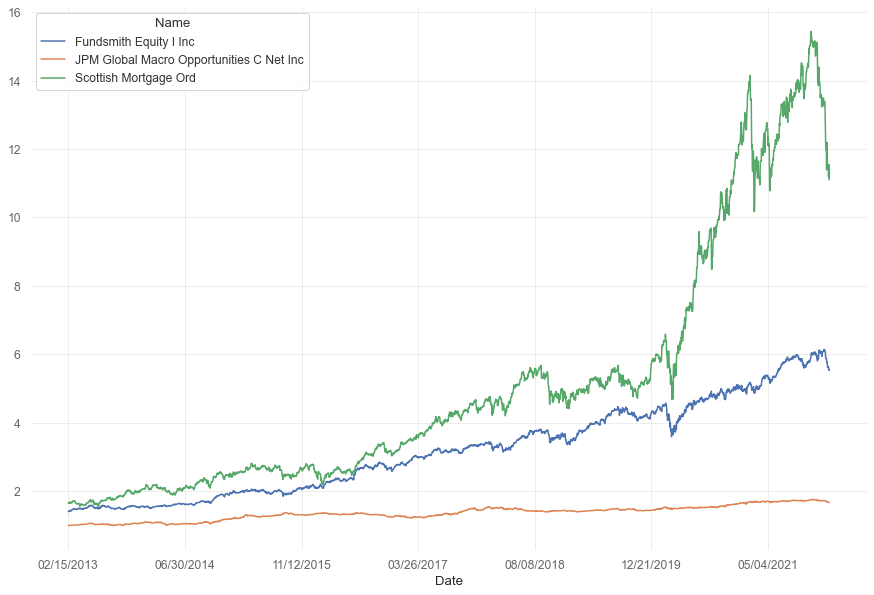

In [106]:
concatenated_df_pivot.plot(figsize=(15,10))

## Calculating the covariance matrix

In [61]:
import pypfopt
pypfopt.__version__

'1.5.1'

In [62]:
from pypfopt import risk_models
from pypfopt import plotting

sample_cov = risk_models.sample_cov(concatenated_df_pivot, frequency=252)
sample_cov

Name,Fundsmith Equity I Inc,JPM Global Macro Opportunities C Net Inc,Scottish Mortgage Ord
Name,,,
Fundsmith Equity I Inc,0.013283,0.002410,0.007838
JPM Global Macro Opportunities C Net Inc,0.002410,0.003225,0.001416
Scottish Mortgage Ord,0.007838,0.001416,0.043757


<AxesSubplot:>

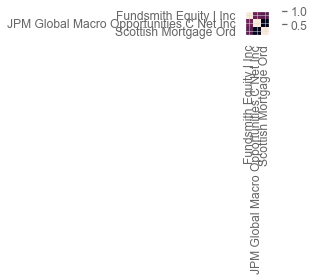

In [63]:
plotting.plot_covariance(sample_cov, plot_correlation=True)

## Return estimation

In [64]:
from pypfopt import expected_returns

mu = expected_returns.capm_return(concatenated_df_pivot)
mu

Name
Fundsmith Equity I Inc                      0.094467
JPM Global Macro Opportunities C Net Inc    0.042315
Scottish Mortgage Ord                       0.187754
Name: mkt, dtype: float64

## Manual Weights

In [110]:
concatenated_df['Name'].unique()

array(['Fundsmith Equity I Inc',
       'JPM Global Macro Opportunities C Net Inc',
       'Scottish Mortgage Ord'], dtype=object)

In [111]:
initial_weights = [0.2, 0.6, 0.2]
unique_fund_names = concatenated_df['Name'].unique()

iterator = zip(unique_fund_names.tolist(), initial_weights)
comb_weights = dict(iterator)
comb_weights

{'Fundsmith Equity I Inc': 0.2,
 'JPM Global Macro Opportunities C Net Inc': 0.6,
 'Scottish Mortgage Ord': 0.2}

In [112]:
generate_performance_metrics(prices_pivot = concatenated_df_pivot, benchmark = 'SPY', title = 'manual_weights', file_text = 'manual_weights', weights = comb_weights)

## Long/short min variance

In [65]:
from pypfopt import EfficientFrontier

In [71]:
S = risk_models.CovarianceShrinkage(concatenated_df_pivot).ledoit_wolf()

# You don't have to provide expected returns in this case
ef = EfficientFrontier(None, S, weight_bounds=(0, None))
ef.min_volatility()
weights = ef.clean_weights()
weights

OrderedDict([('Fundsmith Equity I Inc', 0.06362),
             ('JPM Global Macro Opportunities C Net Inc', 0.90161),
             ('Scottish Mortgage Ord', 0.03478)])

In [72]:
ef.portfolio_performance(verbose=True);

Annual volatility: 5.7%


In [73]:
generate_performance_metrics(prices_pivot = concatenated_df_pivot, benchmark = 'SPY', title = 'min_variance', file_text = 'min_variance', weights = weights)

## Max Sharpe

In [74]:
S = risk_models.CovarianceShrinkage(concatenated_df_pivot).ledoit_wolf()

# You don't have to provide expected returns in this case
ef = EfficientFrontier(mu, S)
ef.max_sharpe()
weights = ef.clean_weights()
weights

OrderedDict([('Fundsmith Equity I Inc', 0.33931),
             ('JPM Global Macro Opportunities C Net Inc', 0.32073),
             ('Scottish Mortgage Ord', 0.33995)])

In [75]:
ef.portfolio_performance(verbose=True);

Expected annual return: 10.9%
Annual volatility: 9.8%
Sharpe Ratio: 0.92


In [76]:
generate_performance_metrics(prices_pivot = concatenated_df_pivot, benchmark = 'SPY', title = 'max_sharpe', file_text = 'max_sharpe', weights = weights)

## Maximise return for a given risk, with L2 regularisation

In [77]:
ef = EfficientFrontier(mu, S)
ef.efficient_risk(target_volatility=0.12)
weights = ef.clean_weights()
weights

OrderedDict([('Fundsmith Equity I Inc', 0.43132),
             ('JPM Global Macro Opportunities C Net Inc', 0.12689),
             ('Scottish Mortgage Ord', 0.44178)])

In [78]:
ef.portfolio_performance(verbose=True)

Expected annual return: 12.9%
Annual volatility: 12.0%
Sharpe Ratio: 0.91


(0.12906214742330374, 0.11999999986210648, 0.9088512295719036)

In [79]:
generate_performance_metrics(prices_pivot = concatenated_df_pivot, benchmark = 'SPY', title = 'max_return_given_risk', file_text = 'max_return_given_risk', weights = weights)

## L2 Regularisation

In [80]:
from pypfopt import objective_functions

# You must always create a new efficient frontier object
ef = EfficientFrontier(mu, S)
ef.add_objective(objective_functions.L2_reg, gamma=0.1)  # gamme is the tuning parameter
ef.efficient_risk(0.15)
weights = ef.clean_weights()
weights

OrderedDict([('Fundsmith Equity I Inc', 0.28838),
             ('JPM Global Macro Opportunities C Net Inc', 0.06341),
             ('Scottish Mortgage Ord', 0.64822)])

In [81]:
ef.portfolio_performance(verbose=True)

Expected annual return: 15.2%
Annual volatility: 15.0%
Sharpe Ratio: 0.88


(0.15163078921789364, 0.1499999991769511, 0.8775385996010056)

In [82]:
generate_performance_metrics(prices_pivot = concatenated_df_pivot, benchmark = 'SPY', title = 'max_return_l2_reg', file_text = 'max_return_L2_reg', weights = weights)

## Efficient semi-variance optimization

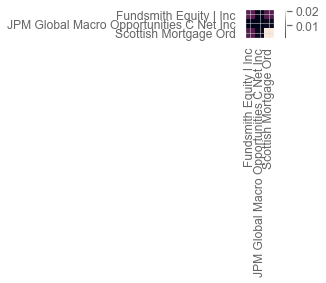

In [83]:
semicov = risk_models.semicovariance(concatenated_df_pivot, benchmark=0)
plotting.plot_covariance(semicov);

In [84]:
ef = EfficientFrontier(mu, semicov)
ef.efficient_return(0.06)
weights = ef.clean_weights()
weights

OrderedDict([('Fundsmith Equity I Inc', 0.11219),
             ('JPM Global Macro Opportunities C Net Inc', 0.80644),
             ('Scottish Mortgage Ord', 0.08137)])

In [85]:
ef.portfolio_performance(verbose=True);

Expected annual return: 6.0%
Annual volatility: 4.4%
Sharpe Ratio: 0.92


In [86]:
generate_performance_metrics(prices_pivot = concatenated_df_pivot, benchmark = 'SPY', title = 'semi_var_opt', file_text = 'semi_var_opt', weights = weights)

## Efficient CVaR optimization

In [87]:
returns = expected_returns.returns_from_prices(concatenated_df_pivot).dropna()
returns.head()

Name,Fundsmith Equity I Inc,JPM Global Macro Opportunities C Net Inc,Scottish Mortgage Ord
Date,,,
02/16/2013,0.000000,0.000000,0.000000
02/17/2013,0.000000,0.000000,0.000000
02/18/2013,0.003759,0.005000,-0.004828
02/19/2013,0.000353,0.000995,0.013948
02/20/2013,0.014832,0.000000,0.009569


In [88]:
ef = EfficientFrontier(mu, S)
ef.max_sharpe()
weight_arr = ef.weights
ef.portfolio_performance(verbose=True);

Expected annual return: 10.9%
Annual volatility: 9.8%
Sharpe Ratio: 0.92


## Plotting - Unconstrained

In [89]:
from pypfopt import CLA, plotting

cla = CLA(mu, S)
cla.max_sharpe()
cla.portfolio_performance(verbose=True);

Expected annual return: 8.6%
Annual volatility: 7.5%
Sharpe Ratio: 0.89


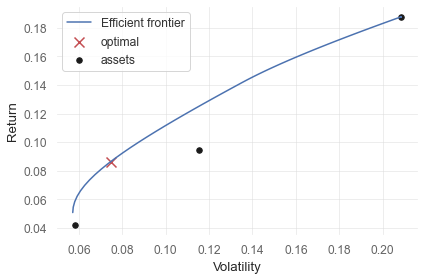

In [90]:
ax = plotting.plot_efficient_frontier(cla, showfig=False)